In [61]:
import numpy as np
import json
from collections import defaultdict
import matplotlib.pyplot as plt


In [62]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import networkx as nx

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['font.size'] = 20
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.markeredgewidth'] = 1.2
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 6
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['font.family'] = 'sans-serif'
cm_colors = plt.get_cmap('Set2')


In [63]:
def cost_maxcut(bitstring, G):
    """
    Computes the cost of a given bitstring solution for the Max-Cut problem.

    Parameters:
    bitstring (str): A binary string representing a partition of the graph nodes (e.g., "1010").
    weights (dict): A dictionary where keys are edge tuples (i, j) and values are edge weights.

    Returns:
    float: The computed cost of the Max-Cut solution.
    """
    cost = 0  # Initialize the cost
    pos_bitstring = {j:i for i, j in enumerate(sorted(G.nodes()))}
    # Iterate through all edges in the graph
    for i, j in G.edges():
        # Check if the nodes i and j are in different partitions (cut condition)
        if bitstring[pos_bitstring[i]] + bitstring[pos_bitstring[j]] in ["10", "01"]:
            cost += G[i][j]["weight"]  # Add the edge weight to the cost

    return cost  # Return the total cut cost


def objective_MaxCut(samples_dict, G, optimal):
    """
    Evaluates the performance of a quantum algorithm for the Max-Cut problem.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    optimal (str): The optimal bitstring solution found by classical solvers (e.g., CPLEX).

    Returns:
    dict: A dictionary containing:
        - "results": A numpy array with computed cost, normalized cost ratio, and counts.
        - "G": The input graph G.
        - "weights": The edge weights extracted from G.
        - "max_cut": The cost of the optimal Max-Cut solution.
        - "r": The expected approximation ratio.
        - "probability": The probability of sampling the optimal solution.
    """

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    
    # Compute the cost of the optimal Max-Cut solution
    max_cost = cost_maxcut(optimal, G)

    results = []  # Stores results in the form [cost, ratio, counts]
    probability = 0  # Tracks probability of sampling the optimal solution

    # Iterate through all sampled bitstrings
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, G)  # Compute cost of the given bitstring
        r = cost / max_cost  # Compute the cost ratio relative to the optimal solution
        results.append([cost, r, counts])  # Store results
        
        # If this bitstring matches the optimal cost, update probability
        if abs(cost - max_cost) < 1e-6:
            probability += counts
        
        # Check if a better-than-optimal solution appears (sanity check)
        if cost > max_cost and cost - max_cost > 1e-10:
            print(f"There is a better cost than that of CPLEX: {cost - max_cost}")

    # Convert results to a NumPy array for easy computation
    results = np.array(results)

    # Total number of shots (total sampled solutions)
    shots = np.sum(results[:, 2])

    # Compute the expected approximation ratio: (weighted sum of costs) / (shots * max_cost)
    rT = np.sum(results[:, 0] * results[:, 2]) / (shots * max_cost)

    # Normalize the probability of sampling the optimal solution
    probability /= shots

    # Return results in a structured dictionary
    return {
        "results": np.array(results),
        "G": G,
        "weights": weights,
        "max_cut": max_cost,
        "r": rT,
        "probability": probability
    }

def mitigate(samples_dict, G, random=False):
    """
    Applies error mitigation by flipping individual bits in sampled solutions 
    to find better Max-Cut solutions.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    random (bool, optional): If True, randomizes the order in which qubits are flipped.
                             Default is False (systematic flipping).

    Returns:
    dict: A dictionary of improved bitstring samples with their updated counts.
    """

    # Define a mapping to flip bits ('0' -> '1', '1' -> '0')
    change = {"0": "1", "1": "0"}

    # Get the number of nodes (qubits)
    nq = G.number_of_nodes()

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}

    # Dictionary to store new (improved) samples
    new_samples = defaultdict(int)

    # Iterate over all bitstring samples
    for bitstring, counts in samples_dict.items():
        for _ in range(counts):  # Process each occurrence of the bitstring separately
            best_string = bitstring  # Initialize the best solution as the current one
            best_cost = cost_maxcut(bitstring, G)  # Compute its cost
            
            # Create an ordered list of qubits (nodes) to consider flipping
            list_qubits = np.arange(nq)
            
            # If random flipping is enabled, shuffle the qubit order
            if random:
                np.random.shuffle(list_qubits)

            # Try flipping each qubit and check if the cost improves
            for qi in list_qubits:
                # Flip the bit at position qi
                new_string = "".join((change[i] if n == qi else i) for n, i in enumerate(best_string))
                new_cost = cost_maxcut(new_string, G)

                # If the new configuration gives a better cost, update the best solution
                if new_cost > best_cost:
                    best_string = new_string
                    best_cost = new_cost
            
            # Store the improved bitstring in the new_samples dictionary
            new_samples[best_string] += 1

    return new_samples  # Return the mitigated samples

def random_samples(num_samples, n_qubits):
    """
    Generates random bitstring samples for a given number of qubits.

    Parameters:
    num_samples (int): The number of random bitstrings to generate.
    n_qubits (int): The number of qubits (length of each bitstring).

    Returns:
    dict: A dictionary where keys are randomly generated bitstrings 
          and values are their occurrence counts.
    """
    
    random_samples = defaultdict(int)  # Dictionary to store bitstrings and their counts

    # Generate random bitstrings and count their occurrences
    for _ in range(num_samples):
        bitstring = "".join(str(i) for i in np.random.choice([0, 1], n_qubits))  # Generate a random bitstring
        random_samples[bitstring] += 1  # Increment count for the generated bitstring

    return random_samples  # Return the dictionary of samples


# Converting graphs

In [32]:
nq = 127
method = "HE"
backend_name = "ibm_brisbane"
results = np.load(f"./Data/{backend_name}/{nq}_{method}.npy", allow_pickle=True).item()
with open(f"./Data/{backend_name}/NL_graph.json", "w") as file:
    graph_info = [[i,j,float(results["G"][i][j]["weight"])] for i,j in results["G"].edges()]
    json.dump(graph_info, file)

# Save samples

In [44]:
with open("/Users/alejomonbar/Documents/GitHub/LR-QAOA-QPU-Benchmarking/Data/ibm_fez/NL_graph.json", "r") as file:
    dict_results = json.load(file)

In [57]:
backend_name = "qiskit_mps"
X = 40
nq = 156
res = np.load(f"./Data/{backend_name}/{nq}_HE_{X}.npy", allow_pickle=True).item()
ps = res["ps"]
r = [res["postprocessing"][0.75][p]["r"] for p in ps]
probs = [res["postprocessing"][0.75][p]["probability"] for p in ps]
with open(f"./Data/NL_{backend_name}_{nq}_{X}.json", "w") as file:
    json.dump({"ps":ps, "r":r, "probability":probs}, file)

In [49]:
with open(f"./Data/{backend_name}_NL.json", "w") as file:
    json.dump({"problem":dict_results, "sol":res["sols"][0]}, file)

In [14]:
import json
nq = 20
X = 20
delta = 1
method = "NL"
extra = ""
backend_name = "iqm_garnet"
with open(f"/Users/alejomonbar/Documents/GitHub/TensorNetworkQuantumSimulator/examples/Data/{nq}_samples_{method}_{X}_{delta}{extra}.json", "r") as file:
    dict_results = json.load(file)

samples = {delta:{}}
for p_layer in sorted([int(i) for i in dict_results.keys()]):
    samples[delta][p_layer]= defaultdict(int)
    for sample in dict_results[str(p_layer)]:
        bitstring = "".join(str(sample[f"(1, {i+1})"]) for i in range(nq))
        samples[delta][p_layer][bitstring] += 1
# method_qpu = "HE" if method == "NL" else method
method_qpu = method
results = np.load(f"/Users/alejomonbar/Documents/GitHub/LR-QAOA-QPU-Benchmarking/Data/{backend_name}/{nq}_{method_qpu}.npy", allow_pickle=True).item()
# results["G"] = G
results["samples"] = samples
results["ps"] = list(sorted(results["samples"][delta].keys()))
np.save(f"/Users/alejomonbar/Documents/GitHub/LR-QAOA-QPU-Benchmarking/Data/TN/{nq}_{method}_{X}_{delta}{extra}.npy", results)


# Postprocessing

In [15]:
backend_name = "TN"
method = "NL"
extra = ""
n_qubits = 20
delta = 1
results = np.load(f"./Data/{backend_name}/{n_qubits}_{method}_{X}_{delta}{extra}.npy", allow_pickle=True).item()


postprocessing = {}
optimal = results["optimal"][0] 
# optimal = results["sol"][0]
postprocessing_mitig = {}
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}
    for p in results["samples"][delta]:
        print(f" -----------  {p}   ---------")
        samples = results["samples"][delta][p]
        # samples = {k[::-1]:v for k, v in samples.items()} 
        postprocessing[delta][p] = objective_MaxCut(samples, results["G"], optimal)
        print(postprocessing[delta][p]["r"])
        # new_samples = mitigate(results["samples"][delta][p], results["G"], random=True)
        # postprocessing_mitig[delta][p] = objective_MaxCut(new_samples, results["G"], results["sols"][0])
results["postprocessing"] = postprocessing
# results["postprocessing_mitig"] = postprocessing_mitig
rand_samples = random_samples(1000, n_qubits)
results["random"] = objective_MaxCut(rand_samples, results["G"], optimal)
# results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=True), results["G"], results["sols"][0])

np.save(f"./Data/{backend_name}/{n_qubits}_{method}_{X}_{delta}{extra}.npy", results)

 -----------  3   ---------
0.7431022727272728


In [20]:
import rustworkx as rx
graph_device = rx.generators.star_graph(5)
graph_device.edge_list()

EdgeList[(0, 1), (0, 2), (0, 3), (0, 4)]

0.897
0.004
0.004
0.004


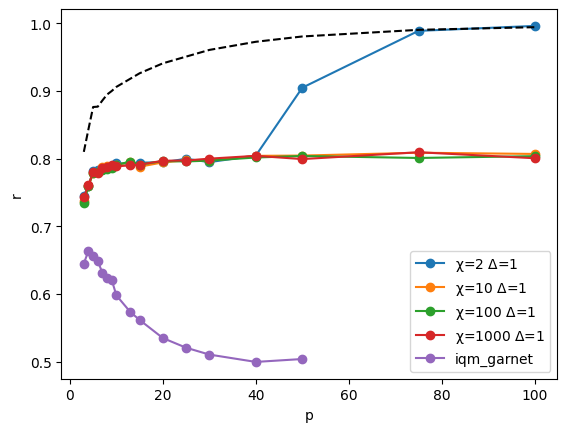

In [4]:
fig, ax = plt.subplots()
nq = 20
method = "NL"
backend_name = "TN"
extra = ""
delta = 1
for X in [2,10,100,1000]:
    results = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}_{delta}{extra}.npy", allow_pickle=True).item()
    print(max([results["postprocessing"][delta][p]["probability"] for p in results["ps"]]))
    ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=rf"χ={X} $\Delta$={delta}")
results = np.load(f"./Data/iqm_garnet/{nq}_{method}.npy", allow_pickle=True).item()
ax.plot(results["ps"], [results["postprocessing"][delta][p][0]["r"] for p in results["ps"]], marker="o", label="iqm_garnet")
graphs = np.load("./Data/NL_regular_graph.npy", allow_pickle=True).item()
ax.plot(graphs["iqm_garnet"][20][0]["ps"], [graphs["iqm_garnet"][20][0][p]["r"] for p in graphs["iqm_garnet"][20][0]["ps"]], color="black", linestyle="--")
ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend()

0.65
0.856
0.901
0.819


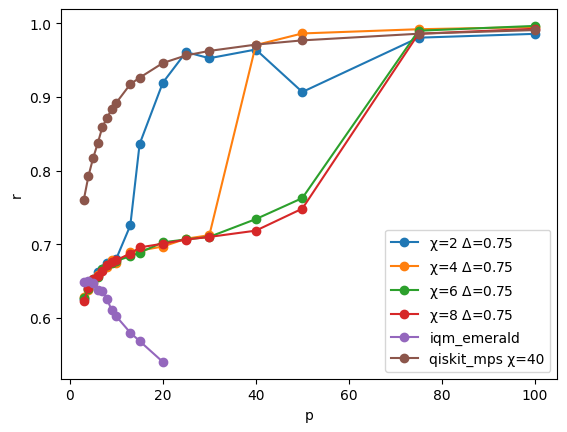

In [112]:
fig, ax = plt.subplots()
nq = 54
method = "NL"
backend_name = "TN"
extra = ""
delta = 0.75
for X in [2,4,6,8]:
    results = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}_{delta}{extra}.npy", allow_pickle=True).item()
    print(max([results["postprocessing"][delta][p]["probability"] for p in results["ps"]]))
    ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=rf"χ={X} $\Delta$={delta}")
results = np.load(f"./Data/iqm_emerald/{nq}_HE.npy", allow_pickle=True).item()
ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label="iqm_emerald")
qpu = np.load(f"./Data/qiskit_mps/{nq}_HE_40.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][0.75][p]["r"] for p in qpu["ps"]], marker="o", label="qiskit_mps χ=40")
ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend()

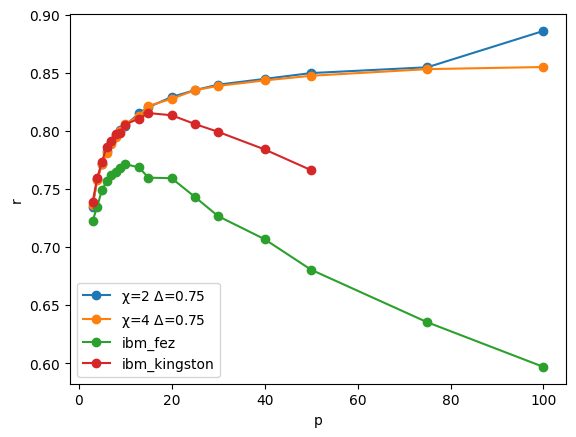

In [24]:
backend_name = "TN"  # Define the IBM backend used for execution

# Specify additional identifier for file naming:

nq = 156  # Number of qubits
sec = 0 
method="NL"
results = {}
fig, ax = plt.subplots()
delta = 0.75

extra = "_fez"
for X in [2,4]:
    results = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}_{delta}{extra}.npy", allow_pickle=True).item()
    ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=rf"χ={X} $\Delta$=0.75")


results = np.load(f"./Data/ibm_fez/{nq}_HE_fractional.npy", allow_pickle=True).item()
ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=rf"ibm_fez")
results = np.load(f"./Data/ibm_kingston/{nq}_HE_fractional.npy", allow_pickle=True).item()
ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=rf"ibm_kingston")

ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend()

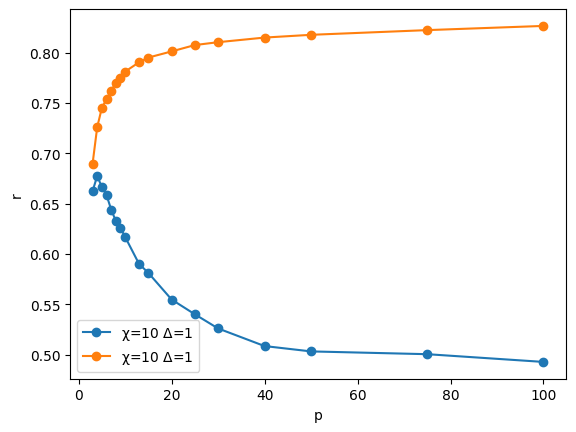

In [54]:
backend_name = "TN"  # Define the IBM backend used for execution

# Specify additional identifier for file naming:

nq = 127  # Number of qubits
sec = 0 
method="NL"
extra = ""
results = {}
fig, ax = plt.subplots()
delta = 1
results = np.load(f"./Data/ibm_brisbane/{nq}_HE_day2.npy", allow_pickle=True).item()
# print(sec, max([results["postprocessing"][delta][p]["probability"] for p in results["ps"]]))
ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=rf"χ={X} $\Delta$={delta}")
for X in [10]:
    results = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}_{delta}{extra}.npy", allow_pickle=True).item()
    ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=rf"χ={X} $\Delta$={delta}")
ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend()


# QAOA training pipeline 

In [57]:
# pip install git+https://github.com/qiskit-community/qaoa_training_pipeline

In [59]:
def energy_fun(sol, graph):
    spin = {"0":-1, "1":+1}
    max_weight = max([graph[i][j]["weight"] for i,j in graph.edges()])
    energy = 0
    for i , j in graph.edges():
        energy += (graph[i][j]["weight"] / max_weight) * spin[sol[i]] * spin[sol[j]]
    return energy

In [68]:
from qaoa_training_pipeline.evaluation import MPSEvaluator
from qaoa_training_pipeline.utils.graph_utils import load_graph, graph_to_operator
import time
nq = 156
graph_type = "HE"
backend_name = "ibm_fez"
data = np.load(f"./Data/{backend_name}/{nq}_{graph_type}.npy", allow_pickle=True).item()
graph = data["G"]
max_weight = max([data["G"][i][j]["weight"] for i, j in data["G"].edges()])

for i, j in data["G"].edges:
    graph[i][j]["weight"] /= max_weight 

# graph = {"edges": [{"nodes":[i,j], "weight":float(G[i][j]["weight"])/2} for i,j in G.edges()],
#          f"Description": "1D chain with {nq} qubits"}
# optimal_energy = energy_fun(data["optimal"][0] if "optimal" in data else data["sol"][0], graph)
optimal_energy = energy_fun(data["sols"][0], graph)


X = 10
cost_op = graph_to_operator(graph)
evaluator = MPSEvaluator(bond_dim_circuit=X)
delta_beta = 0.75
delta_gamma = -0.75
max_energy = sum([graph[i][j]["weight"] for i,j in graph.edges()])
ps = data["ps"]
energies = []
times = []
r = []
for p in ps:
    print(f" p : {p}")
    start = time.time()
    betas = list(np.arange(1, p+1)[::-1] * delta_beta/p)
    gammas = list(np.arange(1, p+1) * delta_gamma/p) 
    energy = evaluator.evaluate(cost_op, betas + gammas)
    energies.append(energy)
    times.append(time.time() - start)
    r_i = (energy - max_energy)/(optimal_energy-max_energy)
    r.append(r_i)
    print(f"r: {r_i}")
# r = [(e - max_energy)/(optimal_energy - max_energy) for e in energies]

np.save(f"./Data/MPS/{nq}_{graph_type}_{X}.npy", {"ps":ps, "time":times, "energies":energies, "r":r, "optimal":optimal_energy})


 p : 3
r: 0.8014684001985929
 p : 4
r: 0.8280909140850599
 p : 5
r: 0.842290693532293
 p : 6
r: 0.8534608318327103
 p : 7
r: 0.861074492909814
 p : 8
r: 0.8655877546826888
 p : 9
r: 0.8706752630987925
 p : 10
r: 0.8762964732605044
 p : 13
r: 0.8886838185989127
 p : 15
r: 0.8951974742690803
 p : 20
r: 0.9095379271908628
 p : 25
r: 0.9167944610562586
 p : 30
r: 0.9249863906559247
 p : 40
r: 0.93922286995044
 p : 50
r: 0.9513022706098565
 p : 75
r: 0.9604393864868502
 p : 100
r: 0.9751960118064754


In [ ]:
from qiskit.circuit.library import qaoa_ansatz
from qiskit.quantum_info import SparsePauliOp

X = 50
cost_op = SparsePauliOp.from_list(data["cost_operator"])
# params = np.array(data["2"]["optimized_qaoa_angles"])
params = np.array(data["1"]["optimized_params"])

evaluator = MPSEvaluator(bond_dim_circuit=X, use_swap_strategy=True)
energy = evaluator.evaluate(cost_op, params)

In [73]:
results

{'approx_ratio': {'5': 0.8554033942558745,
  '20': 0.934727154046996,
  '30': 0.9492924281984338,
  '8': 0.8884960835509129,
  '75': 0.9684934725848557,
  '6': 0.8709020887728454,
  '9': 0.893550913838119,
  '3': 0.8082624020887739,
  '7': 0.8810939947780667,
  '25': 0.9431879895561353,
  '40': 0.9568772845953017,
  '4': 0.8397154046997388,
  '13': 0.9148328981723216,
  '15': 0.9217741514360321,
  '50': 0.9616436031331564,
  '10': 0.9008342036553537,
  '100': 0.9732480417754562},
 'time': [255.54702401161194,
  263.408527135849,
  328.387531042099,
  286.45997381210327,
  333.3426299095154,
  315.5551960468292,
  314.73774003982544,
  380.1425609588623,
  282.8602590560913,
  300.53916788101196,
  293.18303298950195,
  773.9086270332336,
  603.4440159797668,
  603.6518242359161,
  563.7126009464264,
  831.4737010002136,
  933.4042019844055],
 'samples': {'5': {'010100101010101001101010110011001011101101010101001010010100101101001101101010001001101010110101011110010110110101001101101010

In [77]:
results["approx_ratio"].keys()

dict_keys(['5', '20', '30', '8', '75', '6', '9', '3', '7', '25', '40', '4', '13', '15', '50', '10', '100'])

[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.002), np.float64(0.012)]
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.004), np.float64(0.024)]


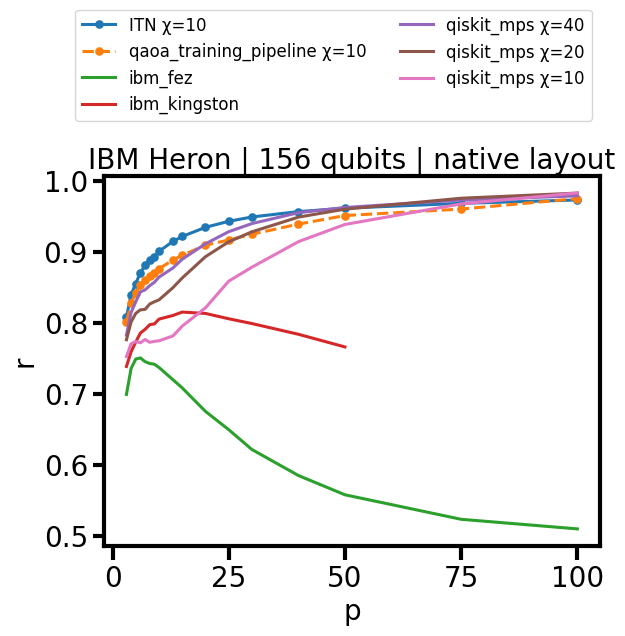

In [78]:
import json
backend_name = "TN"  # Define the IBM backend used for execution

# Specify additional identifier for file naming:
nq = 156 # Number of qubits
sec = 0 
method="NL"
results = {}
fig, ax = plt.subplots()
delta = 0.75
with open("/Users/alejomonbar/Documents/GitHub/Tensor_network_julia/Data/156_NL.json", "r") as file:
    results = json.load(file)
ax.plot(results["ps"], [results["approx_ratio"][str(p)] for p in results["ps"]], marker="o", label=f"ITN χ=10")
for X in [10]:
    results_pipeline = np.load(f"./Data/MPS/{nq}_HE_{X}.npy", allow_pickle=True).item()
    ax.plot(results_pipeline["ps"][-len(results_pipeline["r"]):], results_pipeline["r"], linestyle="--", label=f"qaoa_training_pipeline χ={X}", marker="o")

qpu = np.load(f"./Data/ibm_fez/156_HE.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][1][p]["r"] for p in qpu["ps"]], label="ibm_fez")
qpu = np.load(f"./Data/ibm_kingston/156_HE_fractional.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][0.75][p]["r"] for p in qpu["ps"]], label="ibm_kingston")
qpu = np.load(f"./Data/qiskit_mps/156_HE_40.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][0.75][p]["r"] for p in qpu["ps"]], label="qiskit_mps χ=40")
print([qpu["postprocessing"][0.75][p]["probability"] for p in qpu["ps"]])
qpu = np.load(f"./Data/qiskit_mps/156_HE_20.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][0.75][p]["r"] for p in qpu["ps"]], label="qiskit_mps χ=20")
print([qpu["postprocessing"][0.75][p]["probability"] for p in qpu["ps"]])
qpu = np.load(f"./Data/qiskit_mps/156_HE_10.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][0.75][p]["r"] for p in qpu["ps"]], label="qiskit_mps χ=10")
ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend(loc="center right", bbox_to_anchor=(1, 1.3), ncols=2, fontsize=12)
ax.set_title("IBM Heron | 156 qubits | native layout")
fig.savefig("./Figures/NL/TN_comparison.pdf", transparent=True, bbox_inches="tight")


0 0.0


Text(0.5, 1.0, 'ibm_brisbane | 127 qubits | native layout')

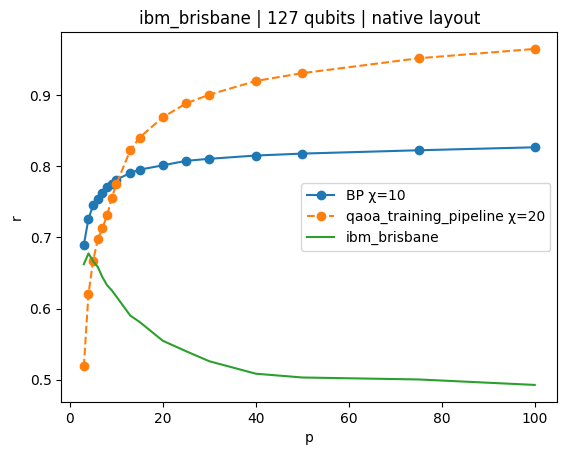

In [275]:
backend_name = "TN"  # Define the IBM backend used for execution

# Specify additional identifier for file naming:
nq = 127 # Number of qubits
sec = 0 
method="NL"
results = {}
fig, ax = plt.subplots()
delta = 1
for X in [10]:
    results = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}_{delta}.npy", allow_pickle=True).item()
    print(sec, max([results["postprocessing"][delta][p]["probability"] for p in results["ps"]]))
    ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=f"BP χ={X}")
for X in [20]:
    results_pipeline = np.load(f"./Data/MPS/{nq}_HE_{X}.npy", allow_pickle=True).item()
    ax.plot(results_pipeline["ps"][:-6], results_pipeline["r"][:-4], linestyle="--", label=f"qaoa_training_pipeline χ={X}", marker="o")

ibm_brisbane = np.load(f"./Data/ibm_brisbane/127_HE_day2.npy", allow_pickle=True).item()

ax.plot(ibm_brisbane["ps"], [ibm_brisbane["postprocessing"][1][p]["r"] for p in ibm_brisbane["ps"]], label="ibm_brisbane")

ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend()
ax.set_title("ibm_brisbane | 127 qubits | native layout")



In [ ]:
backend_name = "TN"  # Define the IBM backend used for execution

# Specify additional identifier for file naming:
nq = 100  # Number of qubits
sec = 0 
method="1D"
results = {}
fig, ax = plt.subplots()

for X in [2,3,4]:
    results = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}.npy", allow_pickle=True).item()
    print(sec, max([results["postprocessing"][1][p][sec]["probability"] for p in results["ps"]]))
    ax.plot(results["ps"], [results["postprocessing"][1][p][sec]["r"] for p in results["ps"]], marker="o", label=f"χ={X}")
for X in [4,10]:
    results_pipeline = np.load(f"./Data/MPS/{nq}_{method}_{X}.npy", allow_pickle=True).item()
    ax.plot(results_pipeline["ps"], results_pipeline["r"], linestyle="--", label=f"qaoa_training_pipeline χ={X}", marker="o")

ibm_brisbane = np.load(f"./Data/ibm_brisbane/{nq}_1D.npy", allow_pickle=True).item()
ibm_fez = np.load(f"./Data/ibm_fez/{nq}_1D.npy", allow_pickle=True).item()

ax.plot(ibm_brisbane["ps"], [ibm_brisbane["postprocessing"][1][p][sec]["r"] for p in ibm_brisbane["ps"]], label="ibm_brisbane")
ax.plot(ibm_fez["ps"], [ibm_fez["postprocessing"][1][p][sec]["r"] for p in ibm_fez["ps"]], label="ibm_fez")

ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend()


0.897
0.005
0.004


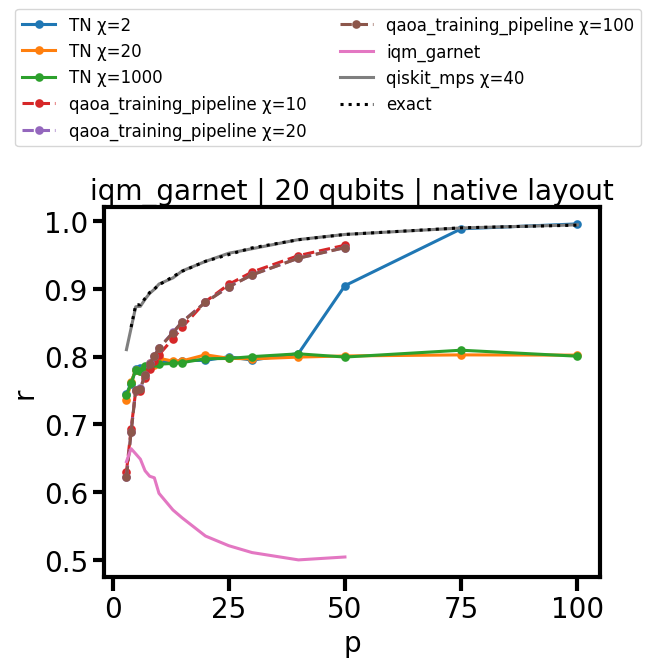

In [47]:
backend_name = "TN"  # Define the IBM backend used for execution

# Specify additional identifier for file naming:
nq = 20 # Number of qubits
method="NL"
results = {}
fig, ax = plt.subplots()
delta = 1
for X in [2, 20,1000]:
    results = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}_{delta}.npy", allow_pickle=True).item()
    print(max([results["postprocessing"][delta][p]["probability"] for p in results["ps"]]))
    ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=f"TN χ={X}")
for X in [10, 20, 100]:
    results_pipeline = np.load(f"./Data/MPS/{nq}_NL_{X}.npy", allow_pickle=True).item()
    ax.plot(results_pipeline["ps"], results_pipeline["r"], linestyle="--", label=f"qaoa_training_pipeline χ={X}", marker="o")

backend_name = "iqm_garnet"
qpu = np.load(f"./Data/{backend_name}/{nq}_{method}.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][1][p][0]["r"] for p in qpu["ps"]], label=f"{backend_name}")
qpu = np.load(f"./Data/qiskit_mps/{nq}_HE_40.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][1][p]["r"] for p in qpu["ps"]], label=f"qiskit_mps χ=40")

graphs = np.load("./Data/NL_regular_graph.npy", allow_pickle=True).item()
ax.plot(graphs["iqm_garnet"][20][0]["ps"][1:], [graphs["iqm_garnet"][20][0][p]["r"] for p in graphs["iqm_garnet"][20][0]["ps"][1:]], color="black", linestyle=":", label="exact")
ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend(loc="center right", bbox_to_anchor=(1.1, 1.35), ncols=2, fontsize=12)
ax.set_title("iqm_garnet | 20 qubits | native layout")
fig.savefig("./Figures/1D-Chain/TN_SQ_comparison.pdf", transparent=True, bbox_inches="tight")

0.001


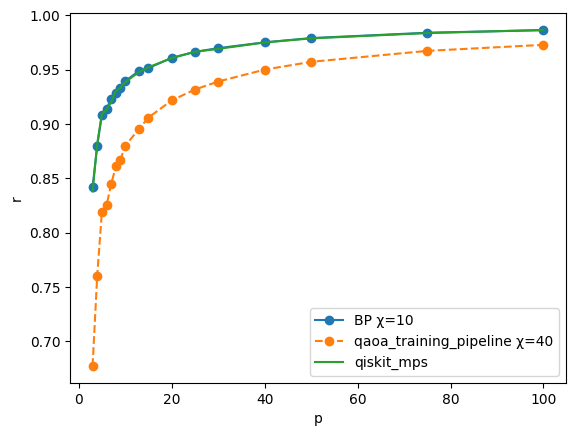

In [96]:
backend_name = "TN"  # Define the IBM backend used for execution

# Specify additional identifier for file naming:
nq = 60 # Number of qubits
method="1D"
results = {}
fig, ax = plt.subplots()
delta = 1
for X in [10]:
    results = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}_{delta}.npy", allow_pickle=True).item()
    print(max([results["postprocessing"][delta][p]["probability"] for p in results["ps"]]))
    ax.plot(results["ps"], [results["postprocessing"][delta][p]["r"] for p in results["ps"]], marker="o", label=f"BP χ={X}")
for X in [40]:
    results_pipeline = np.load(f"./Data/MPS/{nq}_{method}_{X}.npy", allow_pickle=True).item()
    ax.plot(results_pipeline["ps"], results_pipeline["r"], linestyle="--", label=f"qaoa_training_pipeline χ={X}", marker="o")

backend_name = "qiskit_mps"
qpu = np.load(f"./Data/{backend_name}/{nq}_{method}.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][1][p][0]["r"] for p in qpu["ps"]], label=f"{backend_name}")
ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend()
# ax.set_title("iqm_garnet | 20 qubits | native layout")


In [57]:
energies = []
for sample in qpu["samples"][1][3]:
    energies.append(energy_fun(sample, qpu["G"]))

Text(0.5, 1.0, 'Time 156 qubits ibm_fez simulation')

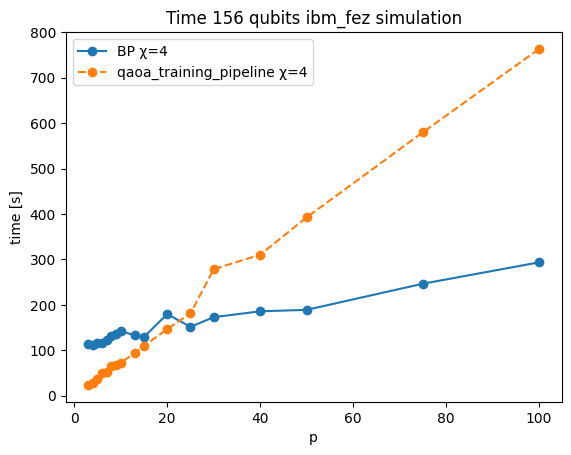

In [278]:
fig, ax = plt.subplots()
nq = 156
delta = 0.75
for X in [4]:
    with open(f"/Users/alejomonbar/Documents/GitHub/TensorNetworkQuantumSimulator/examples/Data/elapsed_time_{nq}_{X}_{delta}_fez.json", "r") as file:
        time_elapsed = json.load(file)
    ax.plot(results["ps"], time_elapsed, label=f"BP χ={X}", marker="o")

    
for X in [4]:
    results_pipeline = np.load(f"./Data/MPS/{nq}_HE_{X}.npy", allow_pickle=True).item()
    ax.plot(results_pipeline["ps"], results_pipeline["time"], linestyle="--", label=f"qaoa_training_pipeline χ={X}", marker="o")

ax.set_ylabel("time [s]")
ax.set_xlabel("p")
ax.legend()
ax.set_title("Time 156 qubits ibm_fez simulation")
# ax.set_ylim(0,00)

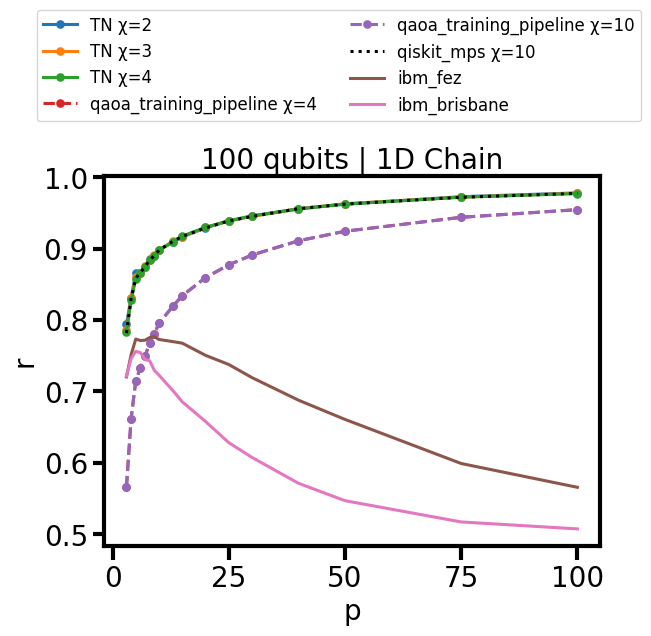

In [39]:
backend_name = "TN"  # Define the IBM backend used for execution

# Specify additional identifier for file naming:
nq = 100 # Number of qubits
method="1D"
results = {}
fig, ax = plt.subplots()
delta = 1
for X in [2,3,4]:
    results = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}.npy", allow_pickle=True).item()
    ax.plot(results["ps"], [results["postprocessing"][delta][p][0]["r"] for p in results["ps"]], marker="o", label=f"TN χ={X}")
for X in [4,10]:
    results_pipeline = np.load(f"./Data/MPS/{nq}_{method}_{X}.npy", allow_pickle=True).item()
    ax.plot(results_pipeline["ps"], results_pipeline["r"], linestyle="--", label=f"qaoa_training_pipeline χ={X}", marker="o")

backend_name = "qiskit_mps"
X = 10
qpu = np.load(f"./Data/{backend_name}/{nq}_{method}_{X}.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][1][p][0]["r"] for p in qpu["ps"]], label=f"{backend_name} χ={X}", color="black", linestyle=":")
backend_name = "ibm_fez"
qpu = np.load(f"./Data/{backend_name}/{nq}_{method}.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][1][p][0]["r"] for p in qpu["ps"]], label=f"{backend_name}")
backend_name = "ibm_brisbane"
qpu = np.load(f"./Data/{backend_name}/{nq}_{method}.npy", allow_pickle=True).item()
ax.plot(qpu["ps"], [qpu["postprocessing"][1][p][0]["r"] for p in qpu["ps"]], label=f"{backend_name}")
ax.set_xlabel("p")
ax.set_ylabel("r")
ax.legend(loc="center right", bbox_to_anchor=(1.1, 1.3), ncols=2, fontsize=12)
ax.set_title("100 qubits | 1D Chain")

fig.savefig("./Figures/1D-Chain/TN_comparison.pdf", transparent=True, bbox_inches="tight")
